/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


(460, 300) (460, 300)


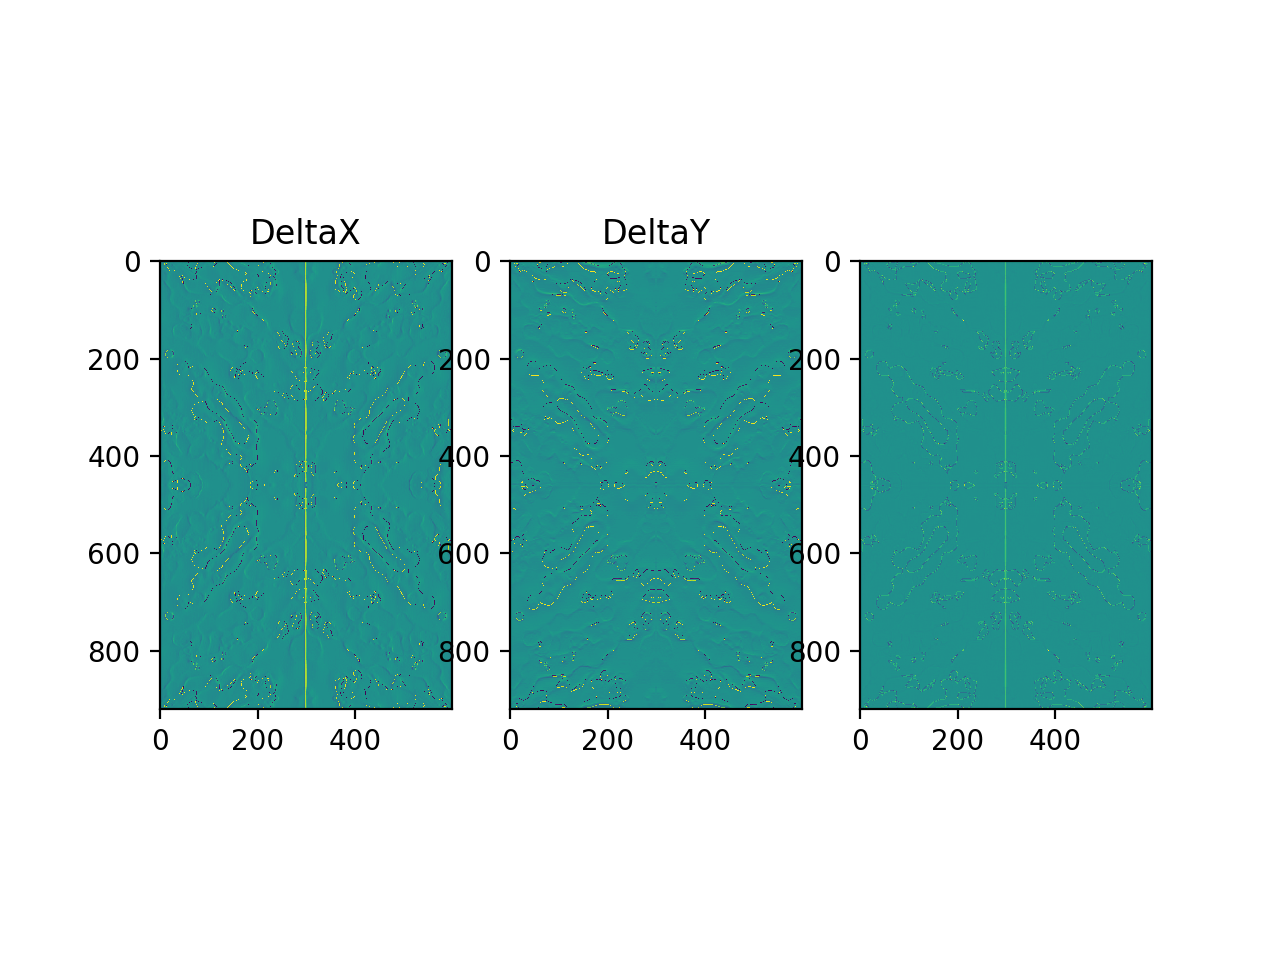

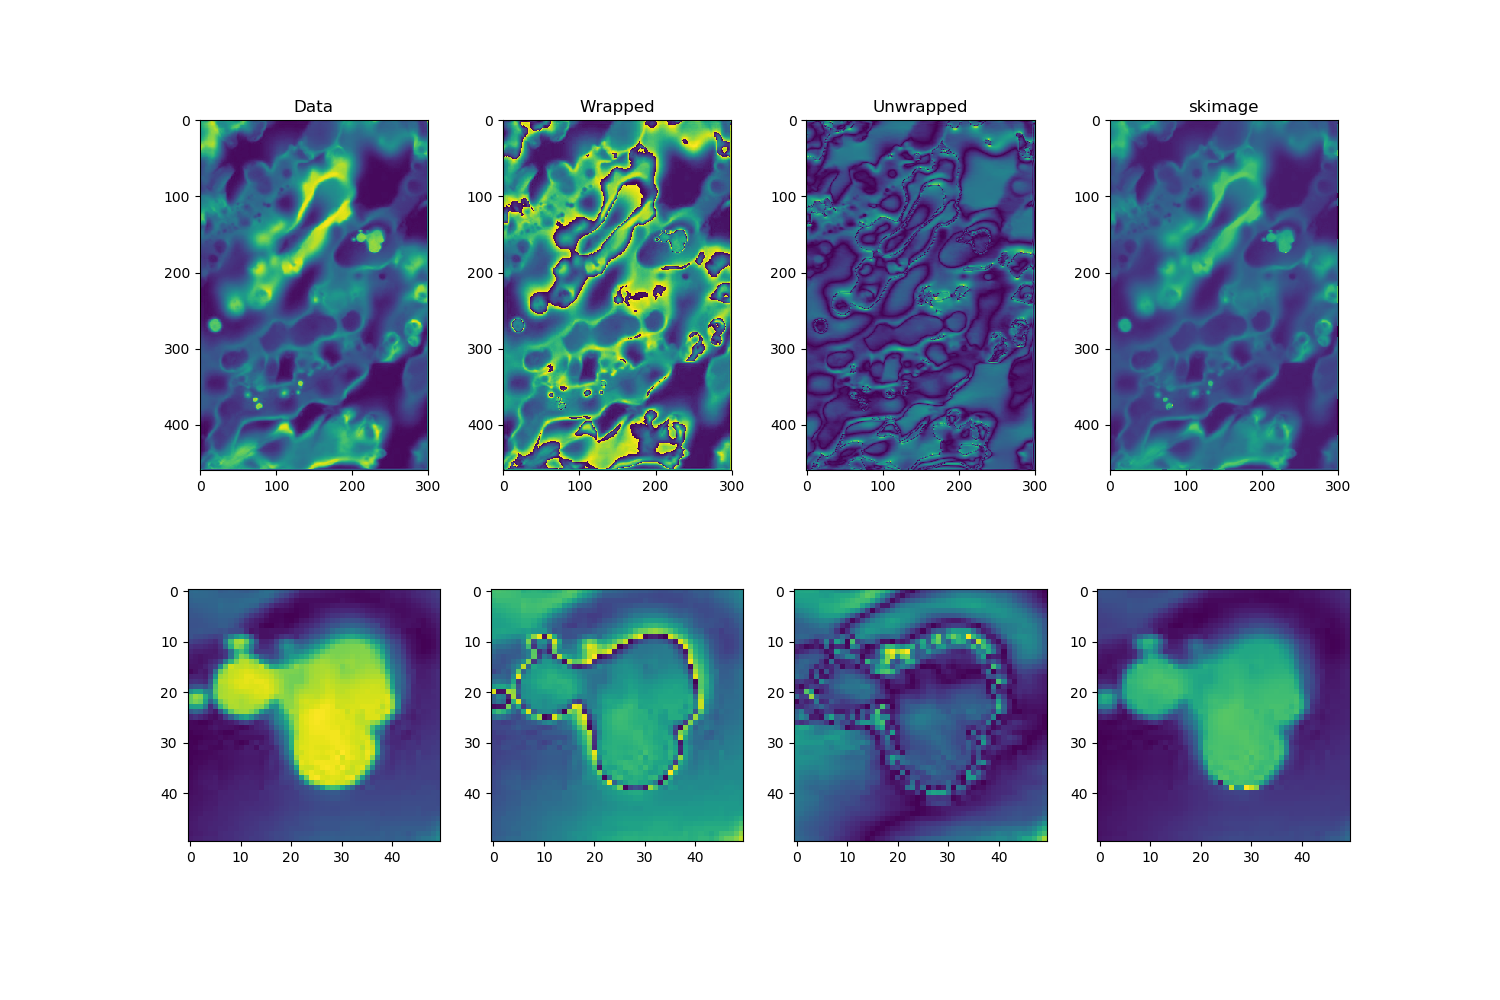

In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, fftfreq
from skimage.restoration import unwrap_phase

data = np.load('corn_fluorescence.npy')

data = (data-np.min(data))/np.max(data)
wrap_factor = 4*np.pi
data = wrap_factor*data - np.pi

wrapped_data = np.angle(np.exp(1j*data))

def PHI(P,X,Y):
    M = Y.shape[0]
    N = X.shape[1]
    arbitrary_additive_constant = 0
    PHI = np.where( X + Y != 0 ,P / (2*np.cos(np.pi*Y/M) + 2*np.cos(np.pi*X/N) - 4), arbitrary_additive_constant)
    return PHI


def mirror_reflect_data(wrapped_data):
    data_flip_vert = np.flip(wrapped_data,axis=1)
    extended_data = np.concatenate((wrapped_data,data_flip_vert[:,1::]),axis=1) # see definition in equation 3 of the paper; M<j<=2M implies we need such slice
    data_flip_horiz = np.flip(extended_data,axis=0)
    full_data = np.concatenate((data_flip_horiz[0:-1,:],extended_data),axis=0) # see definition in equation 3 of the paper; N<k<2N implies we need such slice

    if 0: 
        figure, ax = plt.subplots(1,3,dpi=200)
        ax[0].imshow(wrapped_data), ax[0].set_title('Wrapped')
        ax[1].imshow(data_flip_vert), ax[1].set_title("Flipped")    
        ax[2].imshow(extended_data)

        figure, ax = plt.subplots(1,2,dpi=200)
        ax[0].imshow(wrapped_data), ax[0].set_title('Wrapped')
        ax[1].imshow(full_data), ax[1].set_title("Full")    
        
    return full_data



# rho = np.zeros((data.shape[0]+1,data.shape[1]+1))

extended_data = mirror_reflect_data(wrapped_data)

dx = extended_data - np.roll(extended_data,-1,axis=1)
# dx = dx[0:-1] # remove last column to make it symmetric
dy = extended_data - np.roll(extended_data,1,axis=0)
# dy = dy[1::]

dx_shift = np.roll(dx,-1,axis=1)
dy_shift = np.roll(dy,1,axis=0)
rho = dx - dx_shift + dy - dy_shift

# rho = rho[1::,0:-1] # remove last column to make rho symmetric

if 1:
    figure, ax = plt.subplots(1,3,dpi=200)
    ax[0].imshow(dx), ax[0].set_title('DeltaX')
    ax[1].imshow(dy), ax[1].set_title("DeltaY")
    ax[2].imshow(rho)

# X = np.linspace(0,extended_data.shape[1]-1,extended_data.shape[1])
# Y = np.linspace(0,extended_data.shape[0]-1,extended_data.shape[0])
X = fftshift(fftfreq(rho.shape[1])) # spatial frequency
Y = fftshift(fftfreq(rho.shape[0])) # spatial frequency
X, Y = np.meshgrid(X,Y)



rho_FT = fftshift(fft2(rho))
phi_full = ifft2(fftshift(PHI(rho_FT,X,Y)))
phi_full = np.abs(phi_full)
phi = phi_full[phi_full.shape[0]//2::,0:phi_full.shape[1]//2+1]

print(wrapped_data.shape,phi.shape)

if 1:
    figure, ax = plt.subplots(2,4,figsize=(15,10))
    ax[0,0].imshow(data), ax[0,0].set_title('Data')
    ax[0,1].imshow(wrapped_data),  ax[0,1].set_title("Wrapped")
    ax[0,2].imshow(phi), ax[0,2].set_title("Unwrapped")
    ax[0,3].imshow(unwrap_phase(wrapped_data)), ax[0,3].set_title("skimage")
    ax[1,0].imshow(data[135:185,200:250])
    ax[1,1].imshow(wrapped_data[135:185,200:250])
    ax[1,2].imshow(phi[135:185,200:250])
    ax[1,3].imshow(unwrap_phase(wrapped_data)[135:185,200:250])
    